# Comparison between sklearn's and gensim's implementations of NMF

In [1]:
%load_ext line_profiler
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [2]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:1000])

In [3]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

dictionary.filter_extremes()

2018-06-13 14:18:46,100 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-13 14:18:46,293 : INFO : built Dictionary(17622 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 1000 documents (total 136081 corpus positions)
2018-06-13 14:18:46,321 : INFO : discarding 14411 tokens: [('bricklin', 2), ('bumper', 4), ('edu', 661), ('funki', 4), ('lerxst', 2), ('line', 989), ('organ', 952), ('rac', 1), ('subject', 1000), ('tellm', 2)]...
2018-06-13 14:18:46,323 : INFO : keeping 3211 tokens which were in no less than 5 and no more than 500 (=50.0%) documents
2018-06-13 14:18:46,330 : INFO : resulting dictionary: Dictionary(3211 unique tokens: ['addit', 'bodi', 'brought', 'call', 'car']...)


In [4]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(documents))
proba_bow_matrix = bow_matrix / bow_matrix.sum(axis=0)

## Sklearn NMF

In [5]:
%%time
# %%prun

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(proba_bow_matrix)
H = sklearn_nmf.components_

CPU times: user 1.7 s, sys: 890 ms, total: 2.59 s
Wall time: 1.45 s


In [6]:
# %lprun -f sklearn.decomposition.nmf._fit_coordinate_descent sklearn_nmf.fit_transform(bow_matrix)

In [7]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

5.419692286693165

## Gensim NMF

In [8]:
%%time
# %%prun

PASSES = 2

np.random.seed(42)

gensim_nmf = GensimNmf(
    corpus,
    chunksize=len(corpus),
    num_topics=5,
    id2word=dictionary,
    kappa=1.,
    passes=PASSES,
    eval_every=10,
    normalize=True
)

2018-06-13 14:18:49,027 : INFO : Loss (no outliers): 593.2289895825425	Loss (with outliers): 593.2289895825425


CPU times: user 2.24 s, sys: 2.21 s, total: 4.44 s
Wall time: 1.6 s


In [9]:
# %lprun -f GensimNmf._solve_w GensimNmf(corpus, chunksize=len(corpus), num_topics=5, id2word=dictionary, lambda_=1., kappa=1.)

In [10]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in corpus)

In [11]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

6.357256256235999

In [13]:
gensim_nmf.show_topics()

[(0,
  '0.101*"jesu" + 0.055*"matthew" + 0.042*"peopl" + 0.039*"christian" + 0.026*"prophet" + 0.024*"dai" + 0.023*"messiah" + 0.023*"said" + 0.019*"god" + 0.018*"fulfil"'),
 (1,
  '0.043*"armenian" + 0.028*"peopl" + 0.016*"post" + 0.016*"year" + 0.016*"com" + 0.015*"time" + 0.015*"turkish" + 0.014*"state" + 0.013*"nasa" + 0.013*"space"'),
 (2,
  '0.359*"max" + 0.007*"umd" + 0.005*"hst" + 0.004*"armenian" + 0.003*"health" + 0.002*"father" + 0.002*"us" + 0.002*"gee" + 0.002*"state" + 0.002*"public"'),
 (3,
  '0.055*"health" + 0.049*"jesu" + 0.046*"us" + 0.034*"year" + 0.034*"like" + 0.032*"know" + 0.029*"matthew" + 0.028*"david" + 0.027*"case" + 0.027*"diseas"'),
 (4,
  '0.099*"argument" + 0.060*"conclus" + 0.054*"exampl" + 0.049*"true" + 0.048*"premis" + 0.037*"good" + 0.031*"occur" + 0.030*"logic" + 0.029*"fals" + 0.027*"form"')]

From the personal experience I can say that the higher number of passes and shuffle of the trainset significantly improves performance.

Then, of course, you should perform hyperparameter tuning.

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

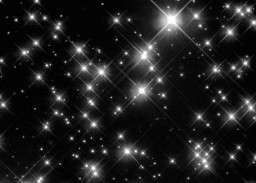

In [14]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [15]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [16]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 209 ms, sys: 180 ms, total: 390 ms
Wall time: 156 ms


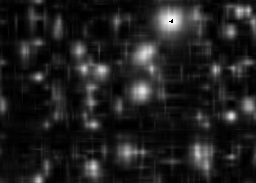

In [17]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [18]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [76]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-06-13 14:26:59,636 : INFO : Loss (no outliers): 4665.057356152667	Loss (with outliers): 4665.057356152667


CPU times: user 164 ms, sys: 4.42 ms, total: 169 ms
Wall time: 166 ms


In [77]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

### Reconstructed matrix:

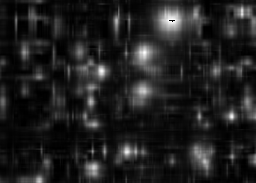

In [78]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')